In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import scrublet as scr
import celltypist
from celltypist import models
import decoupler as dc
import matplotlib.pyplot as plt
import seaborn as sns
sc.set_figure_params(dpi=150)

# Import raw files

In [2]:
inpath="/home/lugli/spuccio/Projects/SP039/FileH5AD_input/"

In [3]:
SF11215 = sc.read(inpath+"SF11215.h5ad")
SF11209 = sc.read(inpath+"SF11209.h5ad")
SF11232 = sc.read(inpath+"SF11232.h5ad")
SF11159 = sc.read(inpath+"SF11159.h5ad")
SF11285 = sc.read(inpath+"SF11285.h5ad")
SF11247 = sc.read(inpath+"SF11247.h5ad")

# Read Metadata

In [4]:
metadata = pd.read_excel('Metadata2.xlsx')

In [5]:
metadata['Sample'] =   [ 'Patient' + str(col) for col in metadata.Sample]

# Fix Metadata 

In [6]:
def fixmeta(metadata,sample,adata):
    tmp1 = metadata.loc[metadata['SampleID'] == sample].loc[metadata.loc[metadata['SampleID'] == sample].index.repeat(adata.shape[0])]
    tmp1.reset_index(drop=True,inplace=True)
    tmp1.set_index( sample+"_"  + tmp1.index.astype(str),inplace=True) 
    adata.obs = tmp1
    return adata

In [7]:
SF11215 = fixmeta(metadata,"SF11215",SF11215)
SF11209 = fixmeta(metadata,"SF11209",SF11209)
SF11232 = fixmeta(metadata,"SF11232",SF11232)
SF11159 = fixmeta(metadata,"SF11159",SF11159)
SF11285 = fixmeta(metadata,"SF11285",SF11285)
SF11247 = fixmeta(metadata,"SF11247",SF11247)

# Concatenate 

In [8]:
SF11215.var_names_make_unique()
SF11209.var_names_make_unique()
SF11232.var_names_make_unique()
SF11159.var_names_make_unique()
SF11285.var_names_make_unique()
SF11247.var_names_make_unique()

In [9]:
adata = SF11215.concatenate(SF11209,SF11232,SF11159,SF11285,SF11247,
                         index_unique=None)

In [ ]:
del(SF11215,SF11209,SF11232,SF11159,SF11285,SF11247)

In [12]:
print(adata.obs['SampleID'].value_counts())
adata

SF11285    11715
SF11247    11033
SF11209     3626
SF11215     2709
SF11159     2624
SF11232     1157
Name: SampleID, dtype: int64


AnnData object with n_obs × n_vars = 32864 × 33419
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch'

In [13]:
adata.layers['raw'] = adata.X 

# Calculate QC

In [14]:
# mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
# ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
# hemoglobin genes.
adata.var['hb'] = adata.var_names.str.contains(("^HB[^(P)]"))

In [15]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)

In [16]:
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mt2'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)

In [17]:
adata

AnnData object with n_obs × n_vars = 32864 × 33419
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'raw'

# Plot QC

... storing 'SampleID' as categorical
... storing 'GEO_RNA' as categorical
... storing 'Cohort' as categorical
... storing 'Type' as categorical
... storing 'Subtype' as categorical
... storing 'Diagnosis' as categorical
... storing 'Grade' as categorical
... storing 'Location' as categorical
... storing 'IDH1_Status' as categorical
... storing 'EGFR_Status' as categorical
... storing 'MGMT' as categorical
... storing 'Sample' as categorical
... storing 'Sex' as categorical
... storing 'Age' as categorical
... storing 'Sorted' as categorical
... storing 'MET' as categorical


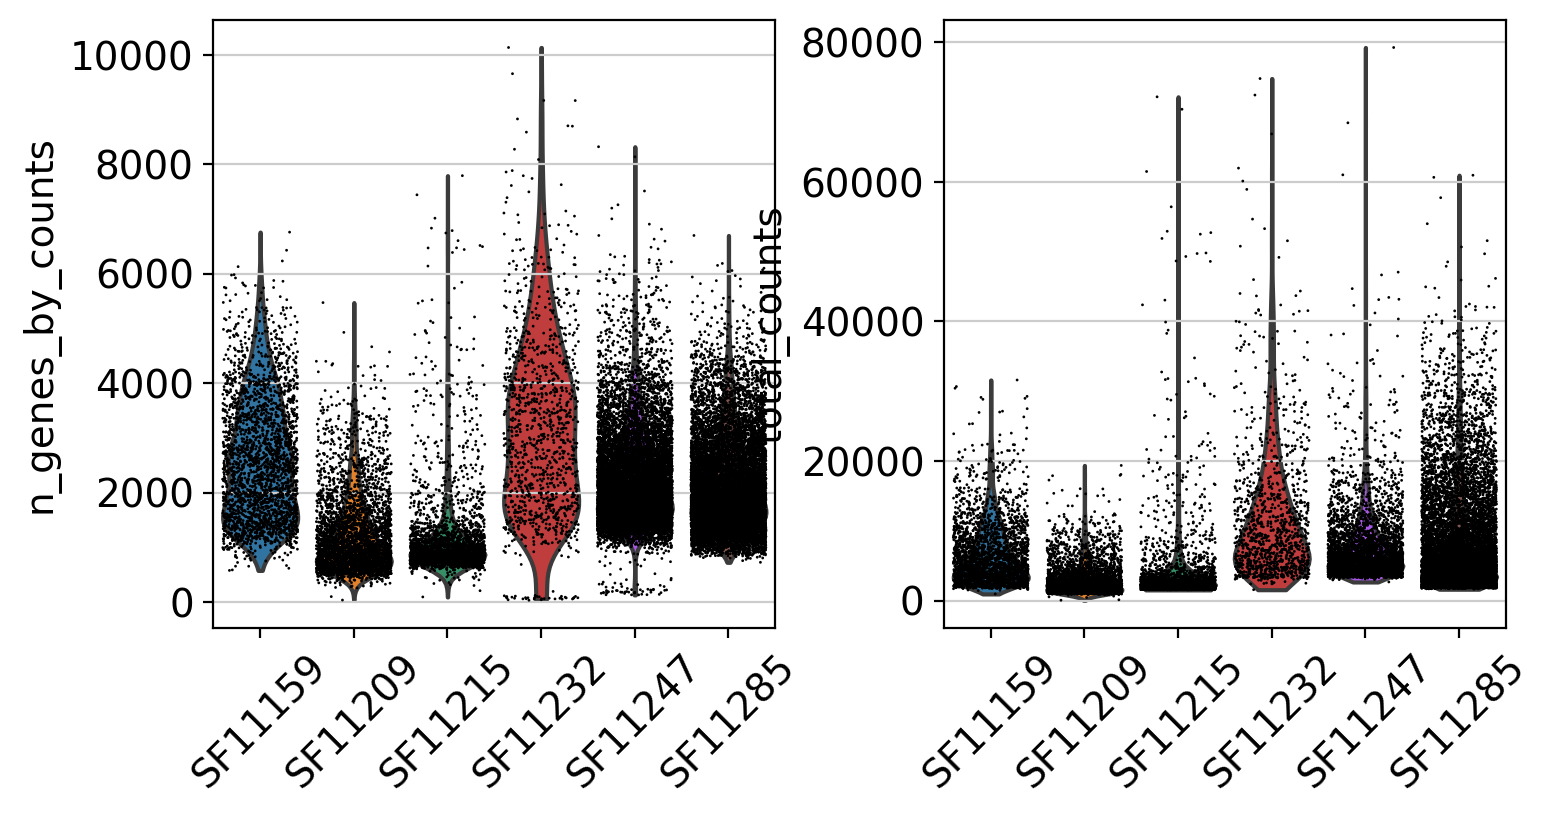

In [18]:
sc.set_figure_params(dpi=100)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, groupby = 'SampleID', rotation= 45)

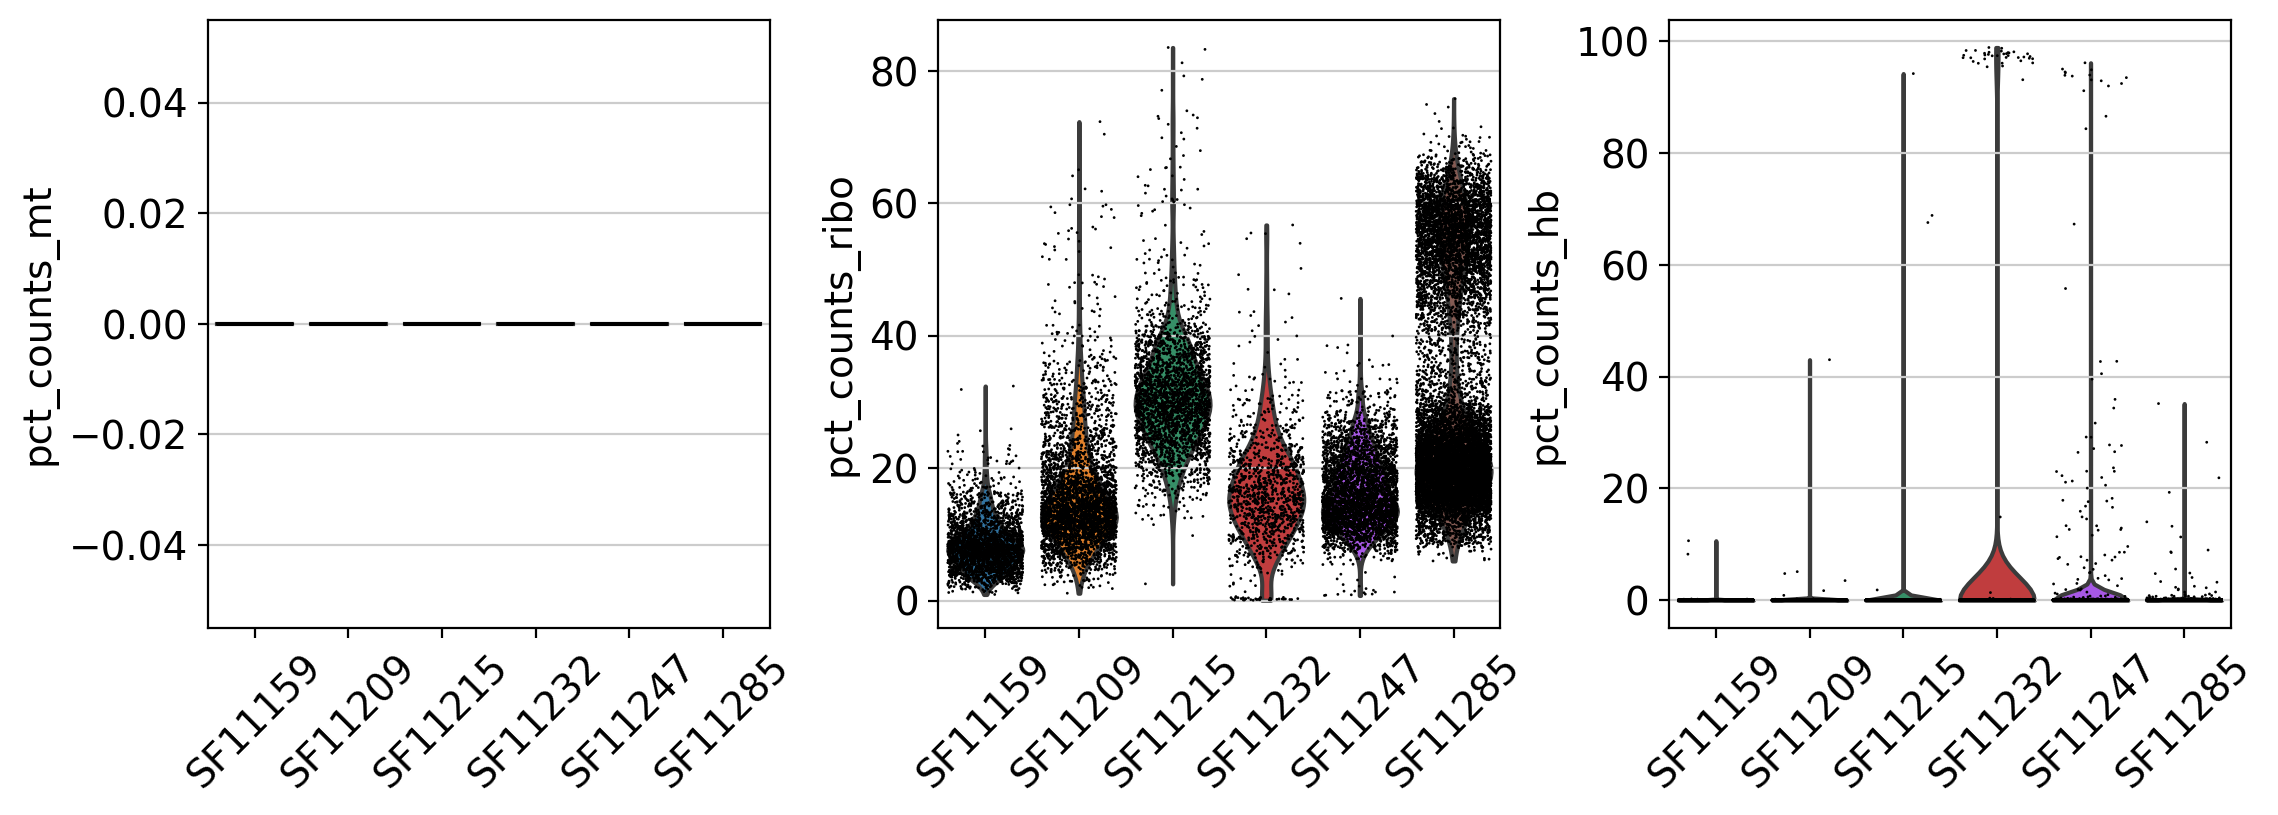

In [19]:
sc.pl.violin(adata, ['pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'SampleID', rotation= 45)

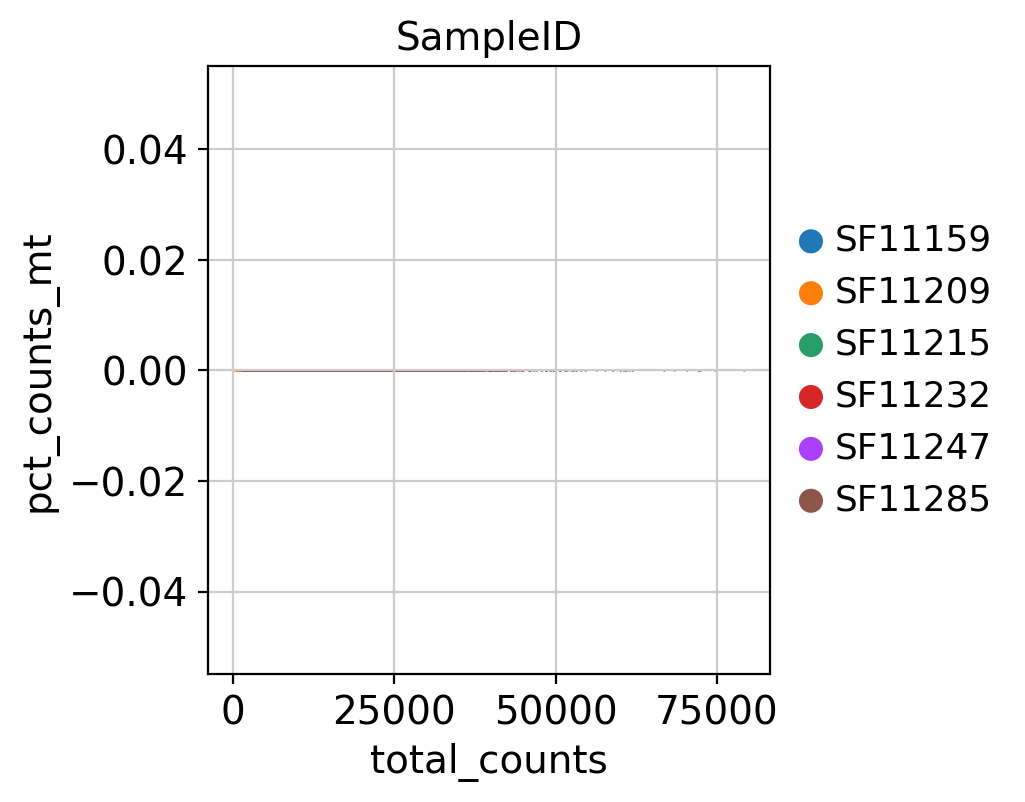

In [20]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color="SampleID")

# Filtering

In [21]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

print(adata.n_obs, adata.n_vars)

32798 25229


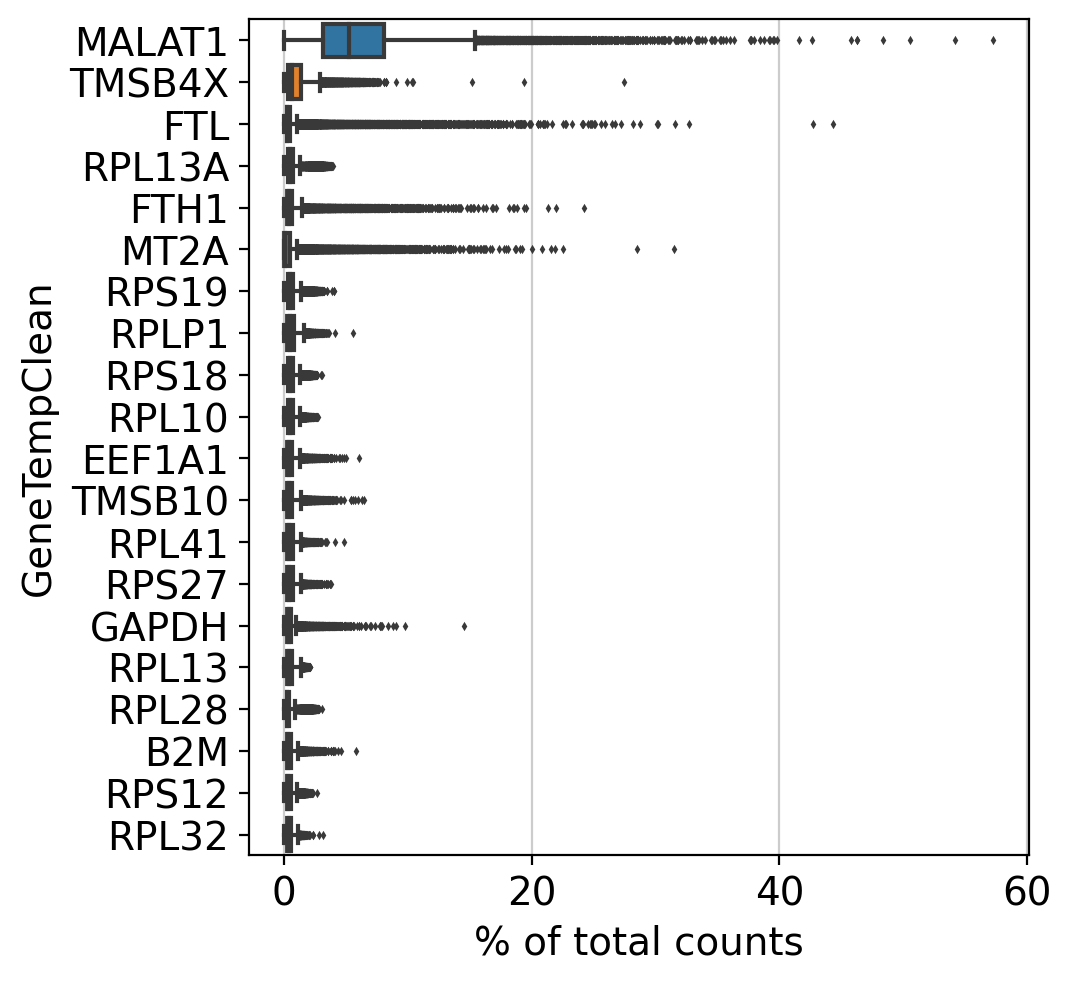

In [22]:
sc.pl.highest_expr_genes(adata, n_top=20)

# Mito/Ribo filtering

In [23]:
adata = adata[adata.obs['pct_counts_mt'] < 20, :]

# filter for percent ribo > 0.05
adata = adata[adata.obs['pct_counts_ribo'] > 2, :]
adata = adata[adata.obs['pct_counts_hb'] < 2, :]
print("Remaining cells %d"%adata.n_obs)

Remaining cells 25319


# Plot filtered QC

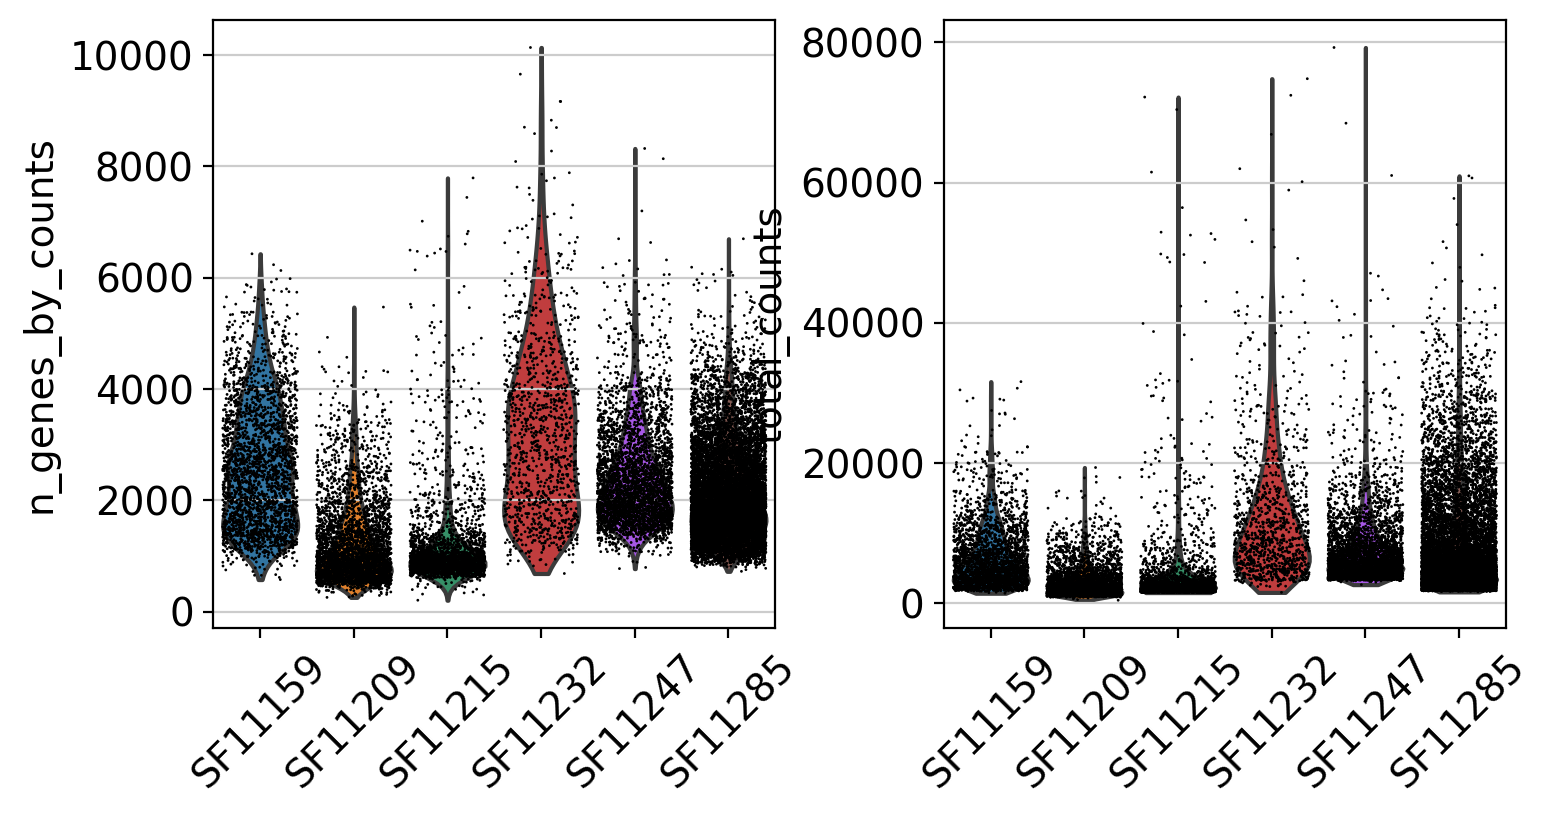

In [24]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, groupby = 'SampleID', rotation= 45)

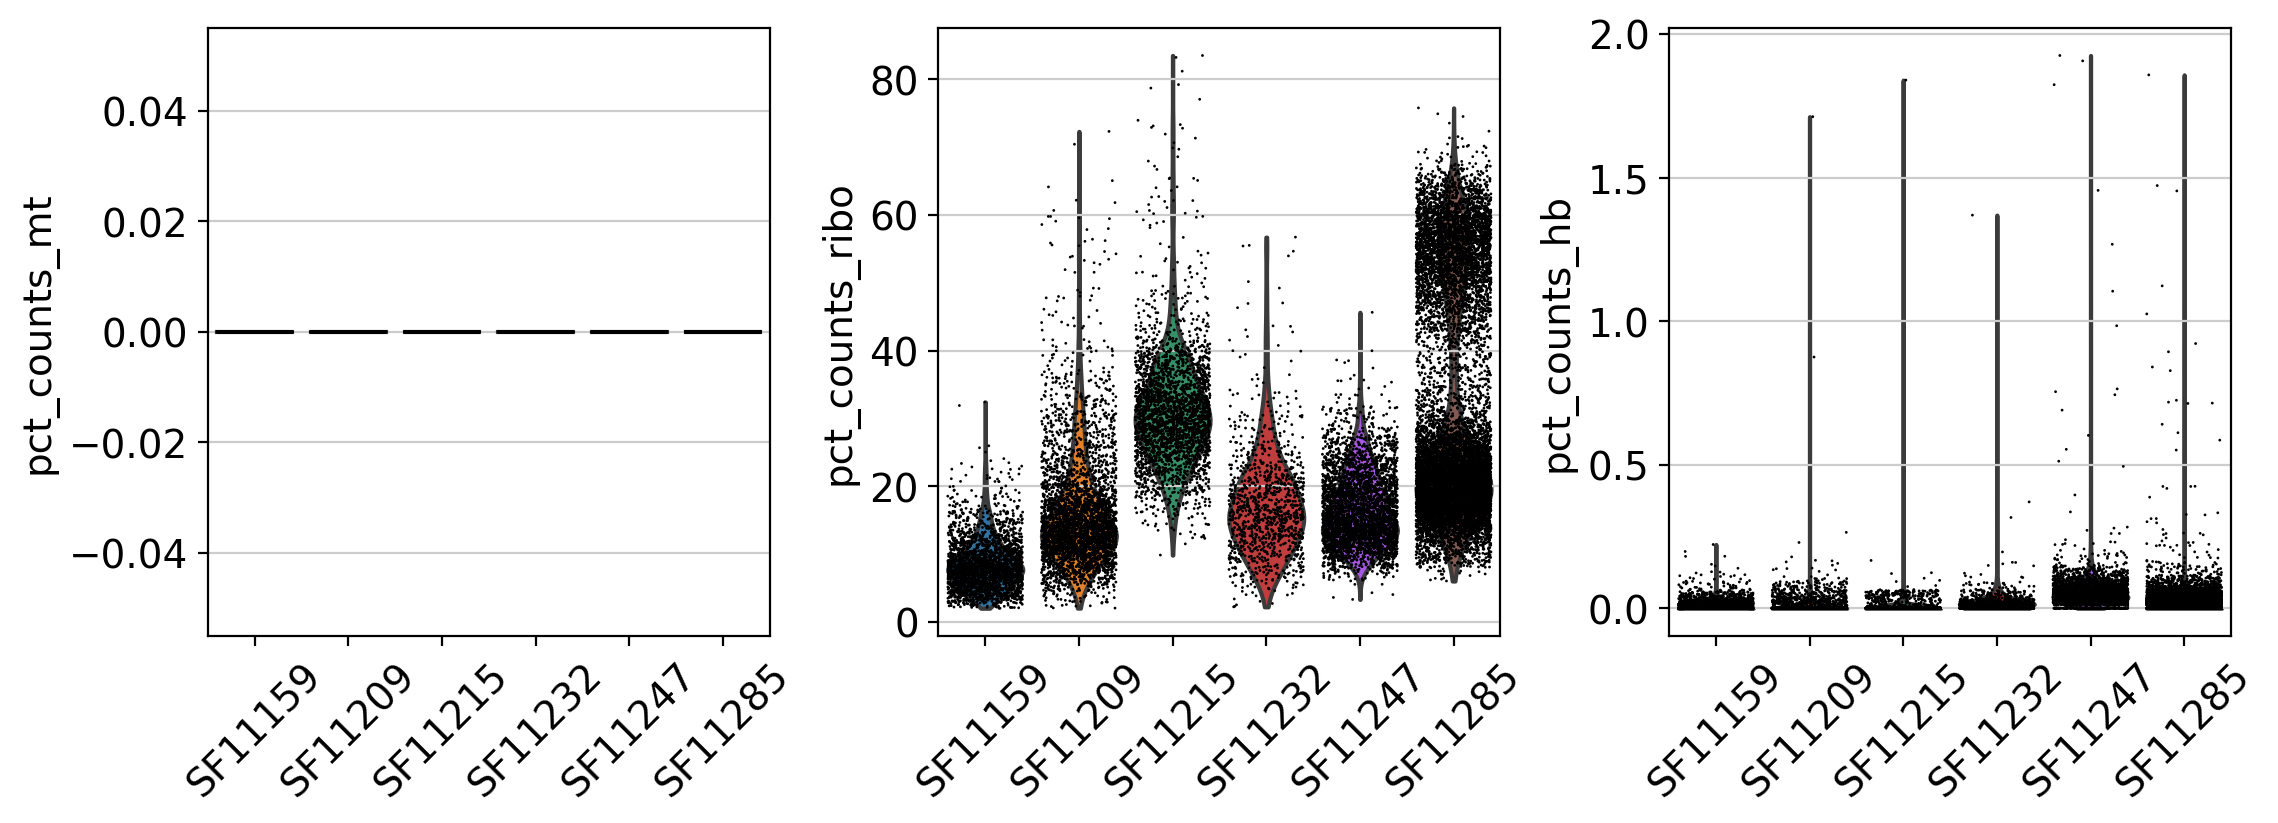

In [25]:
sc.pl.violin(adata, ['pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'SampleID', rotation= 45)

# Filter genes

In [26]:
mito_gene_names = sc.queries.mitochondrial_genes("hsapiens")

In [27]:
mito_gene_indicator = np.in1d(adata.var_names, mito_gene_names)

In [28]:
adata = adata[:, ~mito_gene_indicator]

In [29]:
print(adata.n_obs, adata.n_vars)
malat1 = adata.var_names.str.startswith('MALAT1')
# we need to redefine the mito_genes since they were first 
# calculated on the full object before removing low expressed genes.
ribo_genes = adata.var_names.str.startswith(("RPL","RPS"))
hb_genes = adata.var_names.str.contains('^HB[^(P)]')

remove = np.add(ribo_genes, malat1)
remove = np.add(remove, hb_genes)
keep = np.invert(remove)

adata = adata[:,keep]

print(adata.n_obs, adata.n_vars)

25319 25229
25319 25115


# Calculate cell-cycle scores

In [30]:
cell_cycle_genes = [x.strip() for x in open('/home/lugli/spuccio/Projects/SP035_TregIntegration/Analysis/regev_lab_cell_cycle_genes_homo.txt')]
print(len(cell_cycle_genes))
# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print(len(cell_cycle_genes))

90
88


In [31]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

... storing 'phase' as categorical


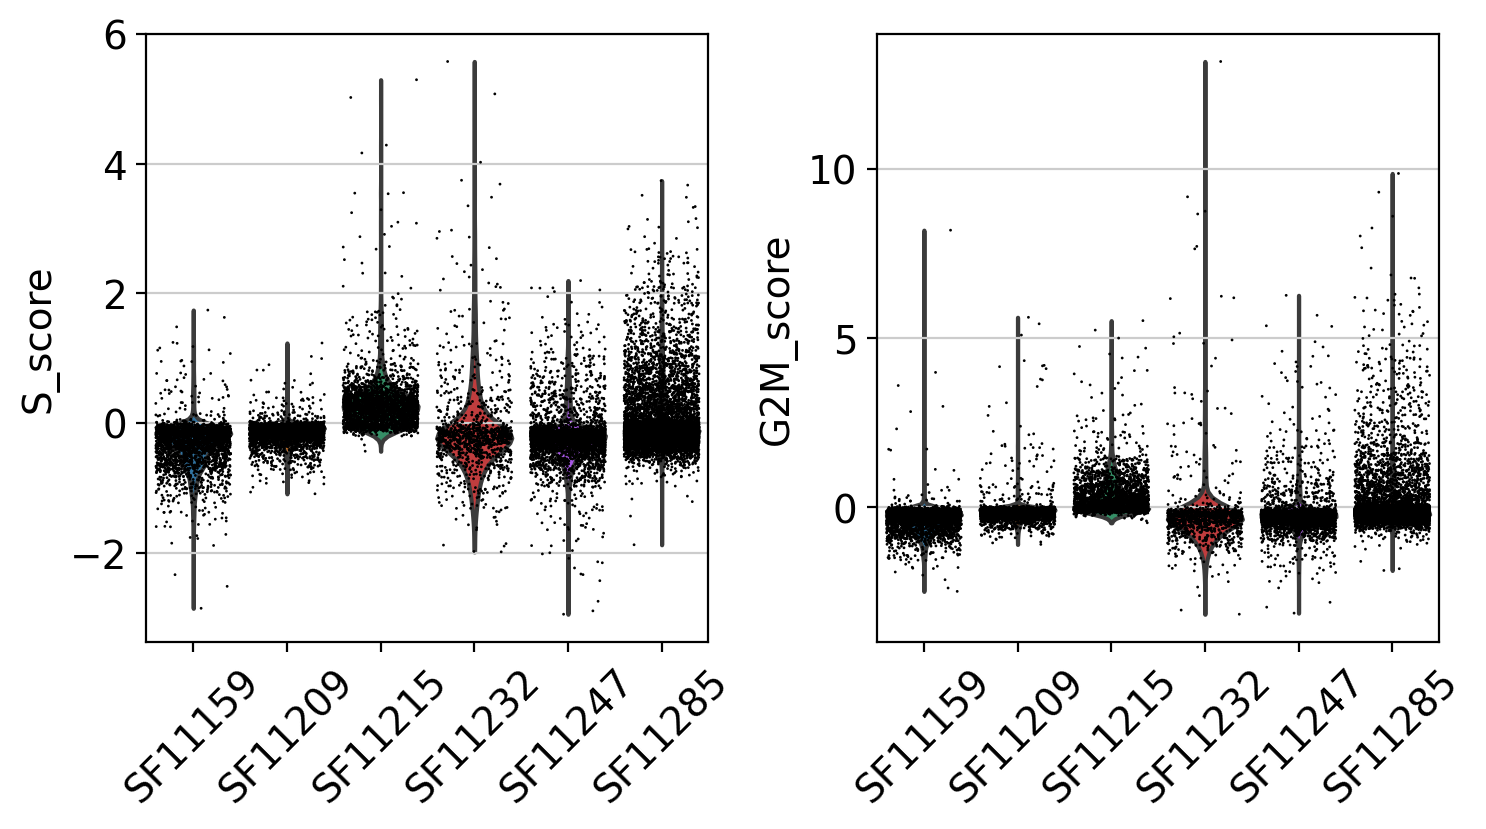

In [32]:
sc.pl.violin(adata, ['S_score', 'G2M_score'],
             jitter=0.4, groupby = 'SampleID', rotation=45)

# Predict doublets

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.66
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 25.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.2%
Elapsed time: 29.2 seconds


14

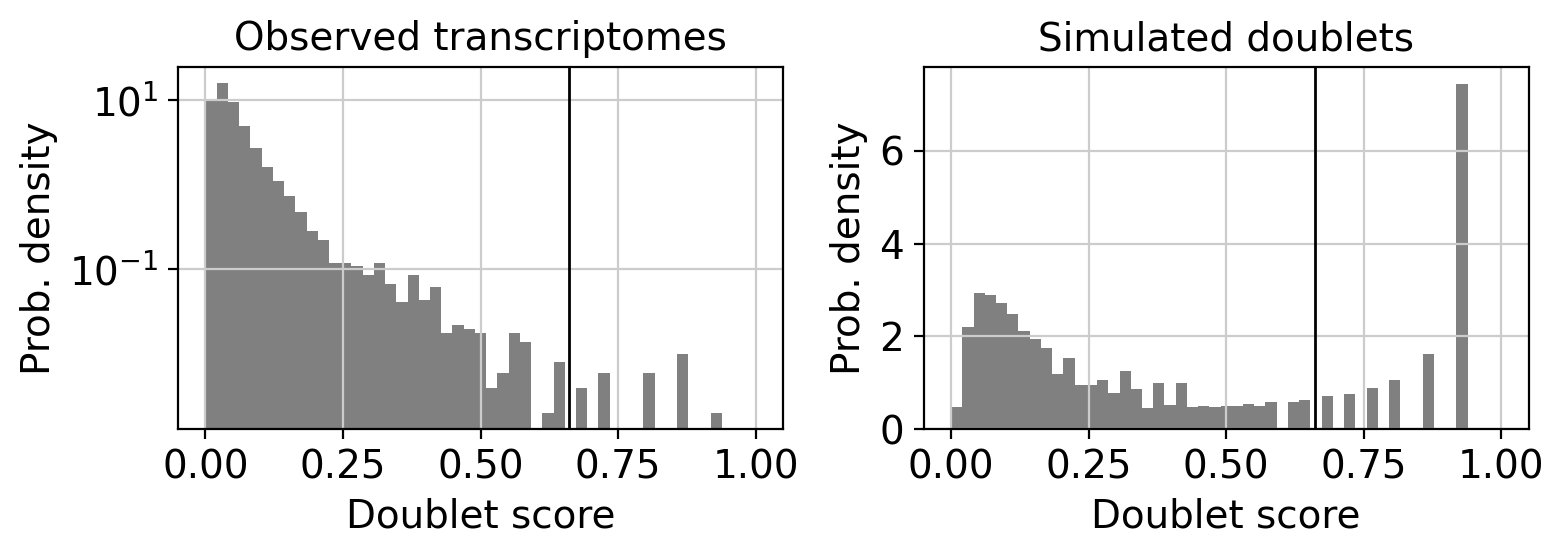

In [33]:
scrub = scr.Scrublet(adata.layers['raw'])
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()

sum(adata.obs['predicted_doublets'])

In [34]:
# add in column with singlet/doublet instead of True/False
adata.obs['doublet_info'] = adata.obs["predicted_doublets"].astype(str)

... storing 'doublet_info' as categorical


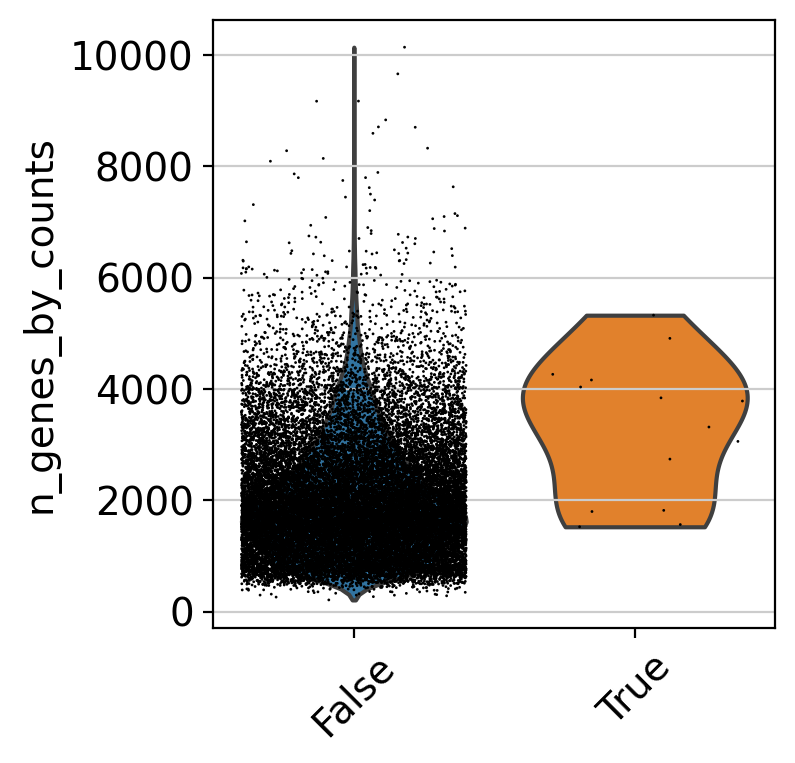

In [35]:
sc.pl.violin(adata, 'n_genes_by_counts',jitter=0.4, groupby = 'doublet_info', rotation=45)

In [36]:
adata = adata[adata.obs['doublet_info'] == "False",:]

# Processing 

In [37]:
#adata = adata[adata.obs.n_genes_by_counts < 3000, :]
# save normalized counts in raw slot.
adata.raw = adata
# normalize to depth 10 000
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
adata.layers['cpm'] = adata.X
# logaritmize
sc.pp.log1p(adata)
adata.layers['log1p'] = adata.X
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# Filter higly variable genes
#adata.raw = adata

# scale
#sc.pp.scale(adata)

# Celltypist classification

In [38]:
sc.tl.pca(adata,svd_solver='arpack',copy=False)

In [39]:
sc.pp.neighbors(adata,n_neighbors=10, n_pcs=40)

In [40]:
sce.pp.harmony_integrate(adata, ['SampleID'])

2022-06-14 17:38:38,004 - harmonypy - INFO - Iteration 1 of 10
Iteration 1 of 10
2022-06-14 17:38:42,220 - harmonypy - INFO - Iteration 2 of 10
Iteration 2 of 10
2022-06-14 17:38:46,398 - harmonypy - INFO - Iteration 3 of 10
Iteration 3 of 10
2022-06-14 17:38:50,569 - harmonypy - INFO - Converged after 3 iterations
Converged after 3 iterations


In [41]:
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_pca_harmony')

In [42]:
sc.tl.umap(adata)

In [43]:
adata.obsm['X_umap_harmony'] = adata.obsm['X_umap']

In [44]:
adata

AnnData object with n_obs × n_vars = 25305 × 25115
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'SampleID_colors', 'doublet_info_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umap_harmony'
    varm: 'PCs'
    layers: 'raw', 'cpm', 'log1p'
    obsp: 'distances', 'connectivities'

In [45]:
models.download_models(force_update = True)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 13
📂 Storing models in /home/lugli/spuccio/.celltypist/data/models
💾 Downloading model [1/13]: Immune_All_Low.pkl
💾 Downloading model [2/13]: Immune_All_High.pkl
💾 Downloading model [3/13]: Immune_All_PIP.pkl
💾 Downloading model [4/13]: Immune_All_AddPIP.pkl
💾 Downloading model [5/13]: COVID19_Immune_Landscape.pkl
💾 Downloading model [6/13]: Cells_Fetal_Lung.pkl
💾 Downloading model [7/13]: Cells_Intestinal_Tract.pkl
💾 Downloading model [8/13]: Cells_Lung_Airway.pkl
💾 Downloading model [9/13]: Developing_Mouse_Brain.pkl
💾 Downloading model [10/13]: Healthy_COVID19_PBMC.pkl
💾 Downloading model [11/13]: Human_Lung_Atlas.pkl
💾 Downloading model [12/13]: Nuclei_Lung_Airway.pkl
💾 Downloading model [13/13]: Pan_Fetal_Human.pkl


In [46]:
model = models.Model.load(model = 'Immune_All_High.pkl')

In [47]:
predictionsHigh = celltypist.annotate(adata, model = 'Immune_All_High.pkl', majority_voting = True)

🔬 Input data has 25305 cells and 25115 genes
🔗 Matching reference genes in the model
🧬 2659 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 15
🗳️ Majority voting the predictions
✅ Majority voting done!


In [48]:
#adata.obs['CellCount']= adata.obs['CellCount'].astype(int)

In [49]:
adata.obs['Sample'].value_counts()

Patient113    11686
Patient110     3617
Patient114     3577
Patient109     2706
Patient112     2599
Patient111     1120
Name: Sample, dtype: int64

In [50]:
adata.write("/home/lugli/spuccio/Projects/SP039/FileH5AD_concatenated/Part1_Q_PRJNA579593_PMID31901251.h5ad")

In [51]:
predictionsHigh.to_adata()

AnnData object with n_obs × n_vars = 25305 × 25115
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'SampleID_colors', 'doublet_info_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umap_harmony'
    varm: 'PCs'
    layers: 'raw', 'cpm', 'log1p'
    obsp: 

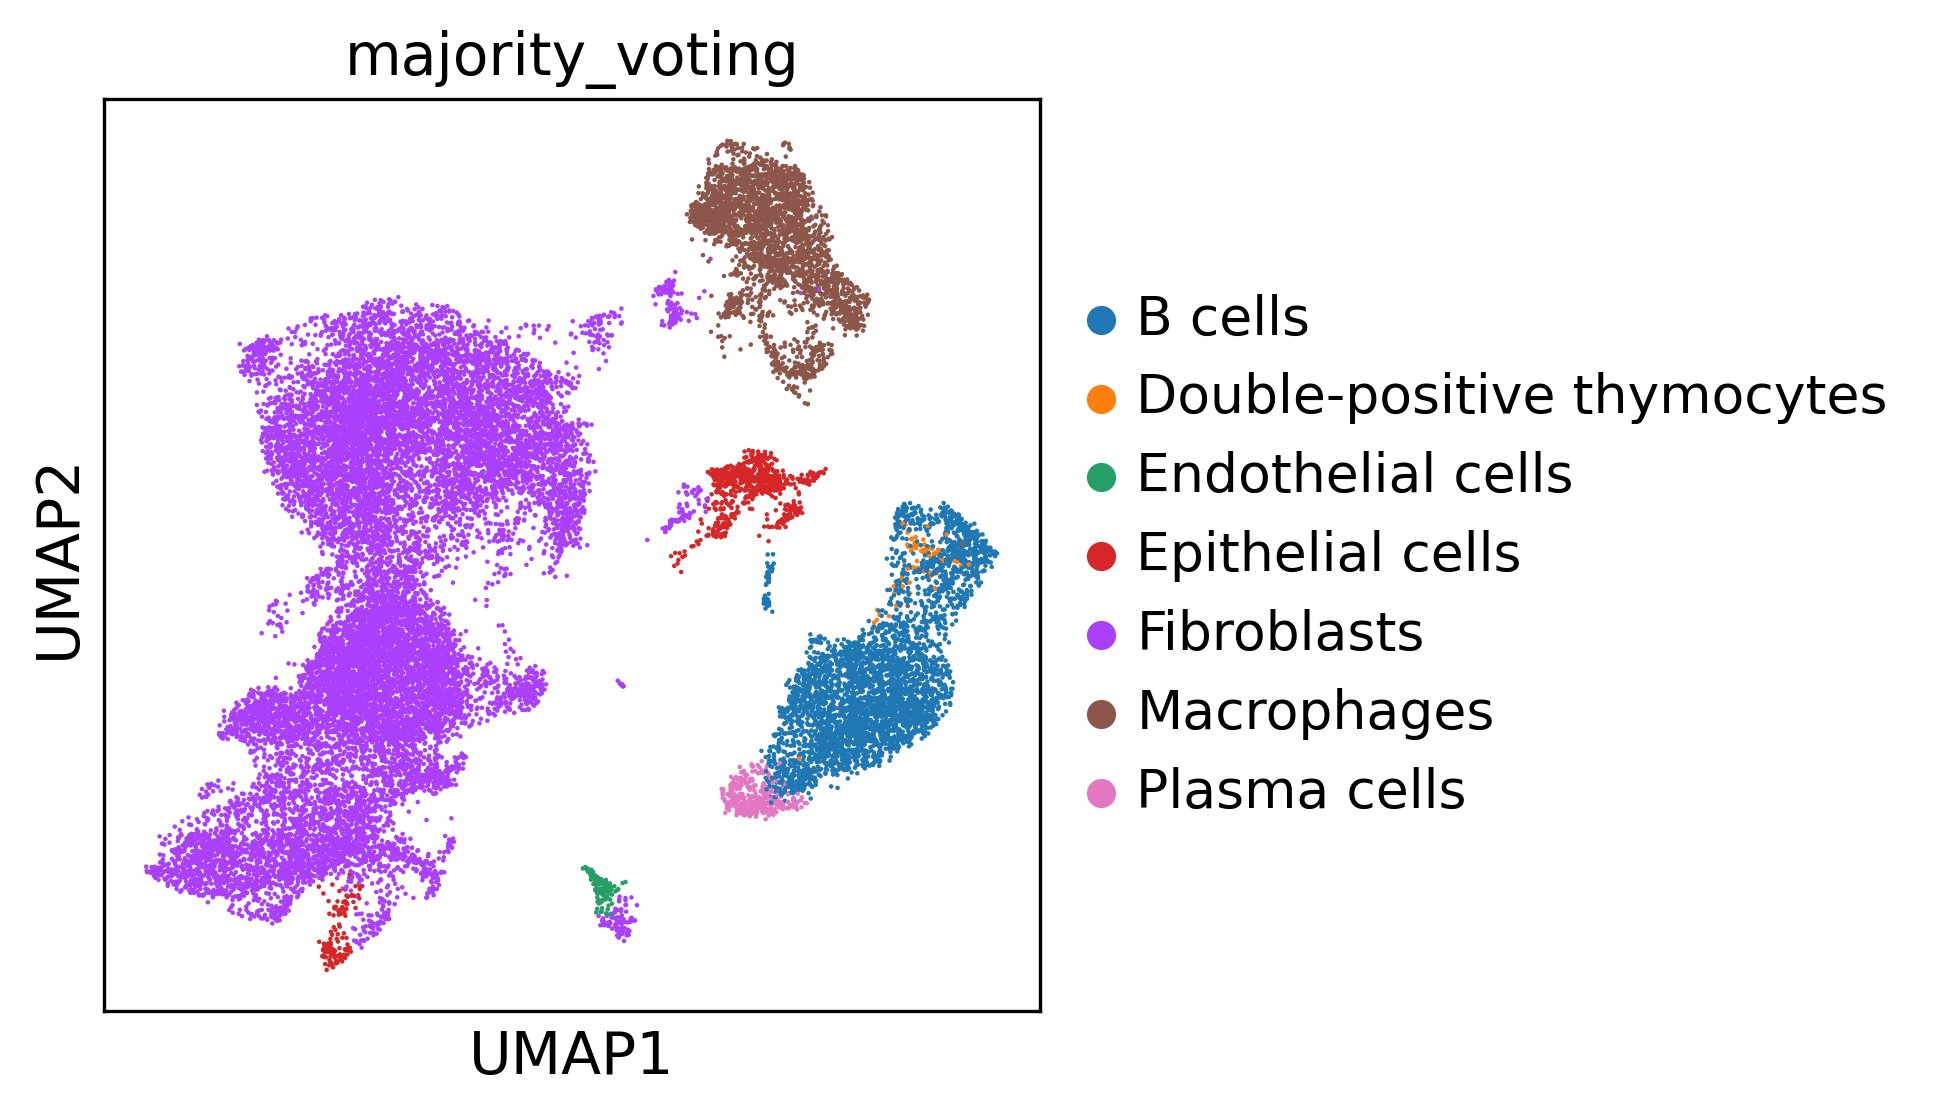

In [52]:
sc.set_figure_params(dpi=150)
sc.pl.umap(predictionsHigh.to_adata(), color='majority_voting')

# PanglaoDB classification

In [53]:
adata = adata[:, adata.var.highly_variable]

In [56]:
markers = dc.get_resource('PanglaoDB')
markers

label genesymbol canonical_marker         cell_type germ_layer human  \
0          CTRB1            False       Enterocytes   Endoderm  True   
1          CTRB1             True      Acinar cells   Endoderm  True   
2           KLK1             True      Acinar cells   Endoderm  True   
3           KLK1            False      Goblet cells   Endoderm  True   
4           KLK1            False  Epithelial cells   Mesoderm  True   
...          ...              ...               ...        ...   ...   
8472     SLC14A1             True  Urothelial cells   Mesoderm  True   
8473       UPK3A             True  Urothelial cells   Mesoderm  True   
8474       UPK1A             True  Urothelial cells   Mesoderm  True   
8475        UPK2             True  Urothelial cells   Mesoderm  True   
8476       UPK3B             True  Urothelial cells   Mesoderm  True   

label human_sensitivity human_specificity mouse mouse_sensitivity  \
0                   0.0        0.00439422  True        0.00331126   
1                   1.0       0.000628931  True          0.957143   
2              0.833333        0.00503145  True          0.314286   
3              0.588235        0.00503937  True          0.903226   
4                   0.0        0.00823306  True          0.225806   
...                 ...               ...   ...               ...   
8472                0.0         0.0181704  True               0.0   
8473                0.0               0.0  True               0.0   
8474                0.0               0.0  True               0.0   
8475                0.0               0.0  True               0.0   
8476                0.0               0.0  True               0.0   

label mouse_specificity ncbi_tax_id            organ ubiquitiousness  
0             0.0204803        9606         GI tract           0.017  
1             0.0159201        9606         Pancreas           0.017  
2             0.0128263        9606         Pancreas           0.013  
3             0.0124084        9606         GI tract           0.013  
4             0.0137585        9606       Epithelium           0.013  
...                 ...         ...              ...             ...  
8472                0.0        9606  Urinary bladder           0.008  
8473                0.0        9606  Urinary bladder             0.0  
8474                0.0        9606  Urinary bladder             0.0  
8475                0.0        9606  Urinary bladder             0.0  
8476                0.0        9606  Urinary bladder             0.0  

[8477 rows x 13 columns]

In [57]:
markers['organ'].value_counts()

Immune system         1775
Brain                 1589
GI tract               540
Kidney                 450
Reproductive           429
Connective tissue      413
Vasculature            372
Pancreas               365
Liver                  310
Epithelium             258
Blood                  247
Bone                   215
Lungs                  210
Skin                   172
Skeletal muscle        168
Olfactory system       136
Heart                  131
Smooth muscle          130
Eye                    122
Mammary gland           94
Zygote                  85
Embryo                  56
Placenta                28
Thymus                  27
Adrenal glands          25
Oral cavity             18
Thyroid                 14
Urinary bladder         11
Parathyroid glands      10
Name: organ, dtype: int64

In [58]:
# Filter by canonical_marker and human
markers = markers[(markers['human']=='True')&(markers['canonical_marker']=='True')]

# Remove duplicated entries
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]
markers

label genesymbol canonical_marker                     cell_type germ_layer  \
1          CTRB1             True                  Acinar cells   Endoderm   
2           KLK1             True                  Acinar cells   Endoderm   
5           KLK1             True               Principal cells   Mesoderm   
7           KLK1             True  Plasmacytoid dendritic cells   Mesoderm   
8           KLK1             True             Endothelial cells   Mesoderm   
...          ...              ...                           ...        ...   
8472     SLC14A1             True              Urothelial cells   Mesoderm   
8473       UPK3A             True              Urothelial cells   Mesoderm   
8474       UPK1A             True              Urothelial cells   Mesoderm   
8475        UPK2             True              Urothelial cells   Mesoderm   
8476       UPK3B             True              Urothelial cells   Mesoderm   

label human human_sensitivity human_specificity mouse mouse_sensitivity  \
1      True               1.0       0.000628931  True          0.957143   
2      True          0.833333        0.00503145  True          0.314286   
5      True               0.0        0.00814536  True          0.285714   
7      True               0.0        0.00820189  True               1.0   
8      True               0.0        0.00841969  True               0.0   
...     ...               ...               ...   ...               ...   
8472   True               0.0         0.0181704  True               0.0   
8473   True               0.0               0.0  True               0.0   
8474   True               0.0               0.0  True               0.0   
8475   True               0.0               0.0  True               0.0   
8476   True               0.0               0.0  True               0.0   

label mouse_specificity ncbi_tax_id            organ ubiquitiousness  
1             0.0159201        9606         Pancreas           0.017  
2             0.0128263        9606         Pancreas           0.013  
5             0.0140583        9606           Kidney           0.013  
7             0.0129136        9606    Immune system           0.013  
8             0.0149153        9606      Vasculature           0.013  
...                 ...         ...              ...             ...  
8472                0.0        9606  Urinary bladder           0.008  
8473                0.0        9606  Urinary bladder             0.0  
8474                0.0        9606  Urinary bladder             0.0  
8475                0.0        9606  Urinary bladder             0.0  
8476                0.0        9606  Urinary bladder             0.0  

[5180 rows x 13 columns]

In [59]:
# Run leiden clustering algorithm
sc.tl.leiden(adata)

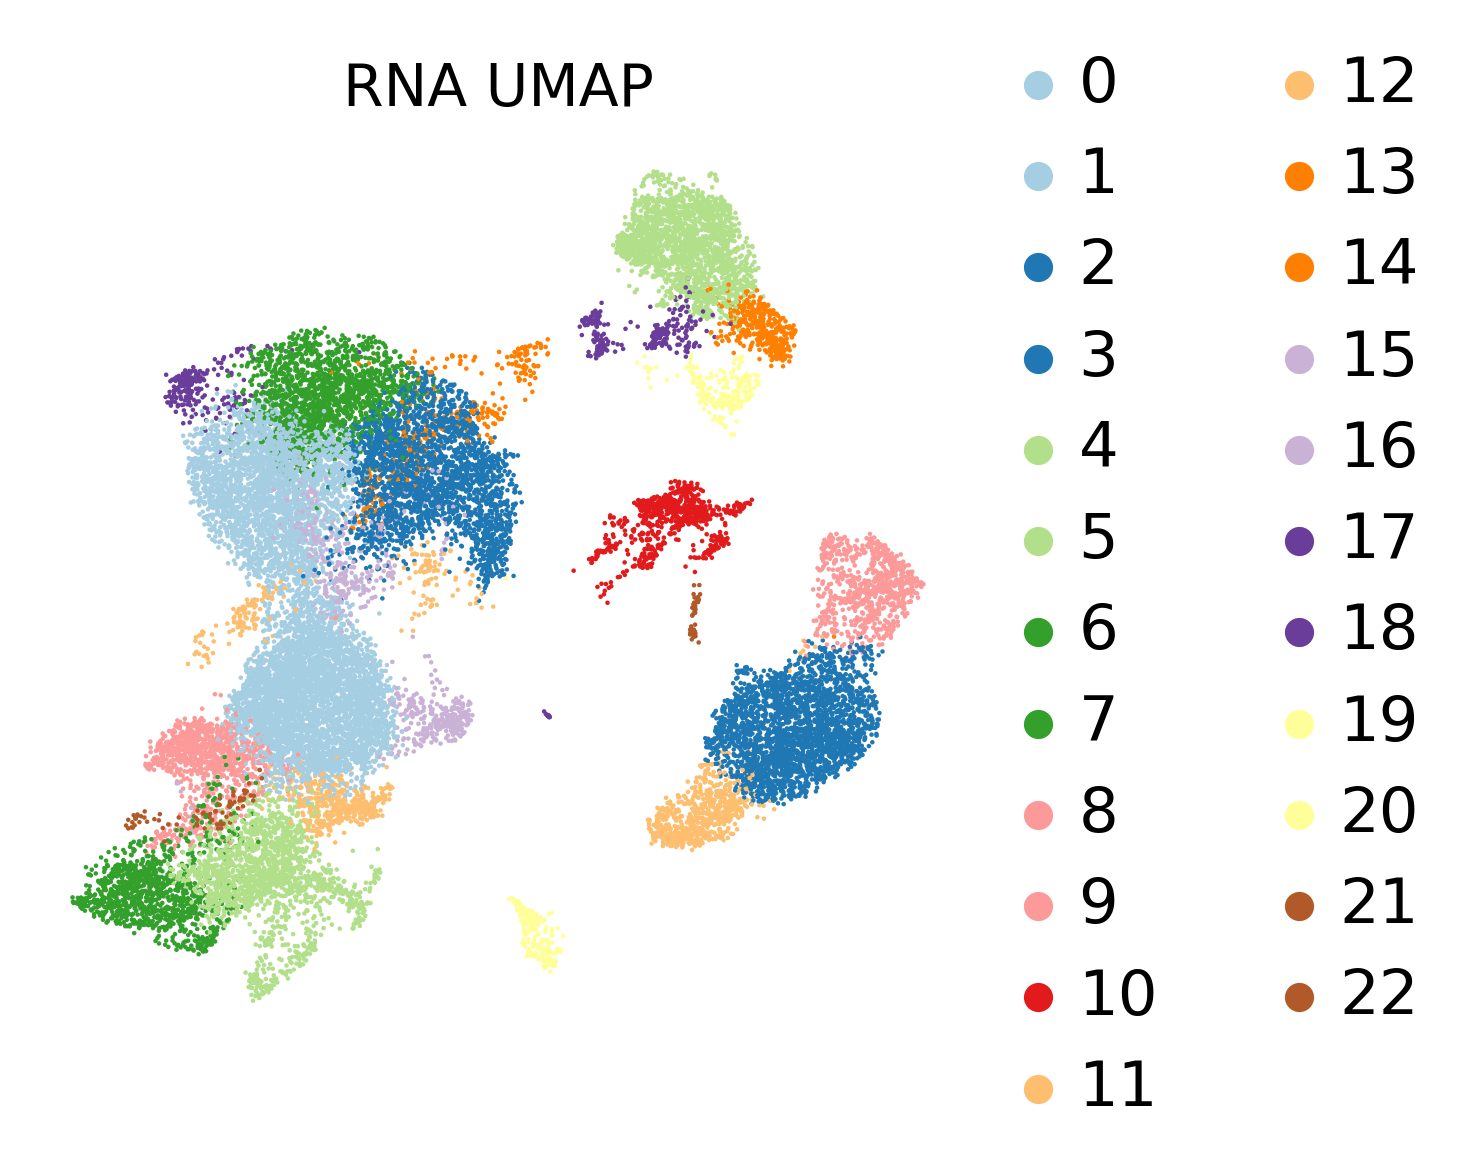

In [60]:
# Visualize
sc.pl.umap(adata, color='leiden', title='RNA UMAP',palette='Paired',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

In [61]:
dc.run_ora(mat=adata, net=markers, source='cell_type', target='genesymbol', min_n=3, verbose=True,use_raw=False)

Running ora on mat with 25305 samples and 2911 targets for 114 sources.


100%|██████████| 25305/25305 [00:08<00:00, 2839.26it/s]


In [62]:
adata.obsm['ora_estimate']

source        Acinar cells  Adipocytes  Airway goblet cells  Alpha cells  \
SF11215_0        -0.000000   -0.000000            -0.000000     1.010908   
SF11215_1        -0.000000    0.731450             1.662709     1.010908   
SF11215_2        -0.000000    0.731450             1.662709     1.010908   
SF11215_3        -0.000000    0.731450            -0.000000     1.010908   
SF11215_4        -0.000000    0.731450             1.662709    -0.000000   
...                    ...         ...                  ...          ...   
SF11247_3659      1.074743    4.312594            -0.000000    -0.000000   
SF11247_3660     -0.000000    7.346353            -0.000000    -0.000000   
SF11247_3661      1.074743    5.779549            -0.000000    -0.000000   
SF11247_3662      1.074743    4.312594            -0.000000    -0.000000   
SF11247_3663     -0.000000    4.312594             1.662709    -0.000000   

source        Alveolar macrophages  Astrocytes   B cells  B cells memory  \
SF11215_0                -0.000000    0.745716  0.886029       -0.000000   
SF11215_1                 1.539343    0.745716  0.886029       -0.000000   
SF11215_2                 1.539343    0.745716  0.886029       -0.000000   
SF11215_3                -0.000000    0.745716 -0.000000       -0.000000   
SF11215_4                 1.539343    0.745716 -0.000000       -0.000000   
...                            ...         ...       ...             ...   
SF11247_3659              1.539343    4.377078 -0.000000       -0.000000   
SF11247_3660             -0.000000    5.862427  2.078686       -0.000000   
SF11247_3661             -0.000000    1.782898  0.886029       -0.000000   
SF11247_3662             -0.000000    3.008659 -0.000000        0.776076   
SF11247_3663             -0.000000    5.862427 -0.000000       -0.000000   

source        B cells naive  Basophils  ...  Sebocytes  Sertoli cells  \
SF11215_0         -0.000000  -0.000000  ...  -0.000000       0.982498   
SF11215_1         -0.000000   0.845649  ...  -0.000000      -0.000000   
SF11215_2         -0.000000   0.845649  ...  -0.000000      -0.000000   
SF11215_3         -0.000000  -0.000000  ...  -0.000000      -0.000000   
SF11215_4         -0.000000   1.993601  ...  -0.000000      -0.000000   
...                     ...        ...  ...        ...            ...   
SF11247_3659      -0.000000   4.829503  ...   1.444005      -0.000000   
SF11247_3660       0.776076   3.337014  ...  -0.000000      -0.000000   
SF11247_3661       0.776076   3.337014  ...  -0.000000      -0.000000   
SF11247_3662      -0.000000   3.337014  ...  -0.000000      -0.000000   
SF11247_3663      -0.000000   1.993601  ...  -0.000000       0.982498   

source        Smooth muscle cells   T cells  T helper cells  \
SF11215_0               -0.000000  0.886029        1.444005   
SF11215_1               -0.000000  0.886029       -0.000000   
SF11215_2               -0.000000  3.469896        3.282583   
SF11215_3                0.776076 -0.000000       -0.000000   
SF11215_4               -0.000000  0.886029       -0.000000   
...                           ...       ...             ...   
SF11247_3659             0.776076  2.078686       -0.000000   
SF11247_3660             1.846960  0.886029       -0.000000   
SF11247_3661             4.514337  0.886029       -0.000000   
SF11247_3662            -0.000000  2.078686       -0.000000   
SF11247_3663            -0.000000  0.886029       -0.000000   

source        T regulatory cells  Tanycytes  Taste receptor cells  Thymocytes  \
SF11215_0              -0.000000   1.150805                  -0.0    1.195001   
SF11215_1              -0.000000  -0.000000                  -0.0   -0.000000   
SF11215_2              -0.000000   1.150805                  -0.0    1.195001   
SF11215_3              -0.000000  -0.000000                  -0.0   -0.000000   
SF11215_4              -0.000000   1.150805                  -0.0   -0.000000   
...                          ...        ...           

In [63]:
adata.obsm['ora_estimate'].columns

Index(['Acinar cells', 'Adipocytes', 'Airway goblet cells', 'Alpha cells',
       'Alveolar macrophages', 'Astrocytes', 'B cells', 'B cells memory',
       'B cells naive', 'Basophils',
       ...
       'Sebocytes', 'Sertoli cells', 'Smooth muscle cells', 'T cells',
       'T helper cells', 'T regulatory cells', 'Tanycytes',
       'Taste receptor cells', 'Thymocytes', 'Tuft cells'],
      dtype='object', name='source', length=114)

In [64]:
acts = dc.get_acts(adata, obsm_key='ora_estimate')
acts

AnnData object with n_obs × n_vars = 25305 × 114
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'leiden'
    uns: 'SampleID_colors', 'doublet_info_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'majority_voting_colors', 'leiden_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umap_harmony', 'ora_estimate', 'ora_pvals'

In [65]:
mean_enr = dc.summarize_acts(acts, groupby='leiden', min_std=1)
mean_enr

Adipocytes  Astrocytes    B cells  B cells memory  B cells naive  \
0     1.545076    3.386072   0.983535        0.359196       0.331588   
1     2.850915    7.955456   0.463653        0.114503       0.206101   
10    0.502615    2.603736   0.659767        0.556220       0.479533   
11    1.904695    2.146373   0.804457        0.223919       0.503950   
12    1.393309    0.340873  18.652220       14.076652      14.199446   
13    3.134824    3.970951   0.763593        0.190615       0.439585   
14    2.397461    2.049280   2.462060        1.461835       2.090624   
15    1.021340    2.637658   0.963807        0.363732       0.389929   
16    2.870152    4.652987   1.091252        0.123391       0.399560   
17    2.330109    2.921014   2.969771        1.182325       1.680268   
18    2.980604   14.522529   0.933828        0.253163       0.509387   
19    3.059081    2.014577   6.808603        5.106250       6.042284   
2     0.988431    0.323070  24.297682       18.939512      20.912220   
20    0.624022    1.336908   1.006253        0.545606       0.912751   
21    1.562488    2.138030   0.417335        0.127574       0.135651   
22    0.399619    0.915378  19.997446       14.435123      16.095007   
3     2.954376    3.080128   0.484116        0.061141       0.292896   
4     2.954934    2.372345   3.064208        2.056300       2.416412   
5     0.971633    1.780177   0.944975        0.170078       0.187785   
6     3.605583    6.179210   0.896165        0.042231       0.377515   
7     0.739740    1.446572   0.766886        0.125377       0.152187   
8     0.775252    1.383762   1.068669        0.168529       0.216559   
9     0.939643    0.125897  22.016197       15.028493      17.626669   

    Bergmann glia  Dendritic cells  Endothelial cells  Ependymal cells  \
0        1.697545         0.818276           2.544919         2.550971   
1        6.966535         1.710623           6.842355         3.916115   
10       0.947635         0.821418           4.455734         1.548926   
11       2.038344         1.821431           2.654739         0.982090   
12       0.296800         5.840968           1.775751         0.175979   
13       3.392385         5.257228           6.768126         2.173561   
14       0.904558        17.369341           4.005479         0.751216   
15       1.018078         1.040249           2.904004         1.980433   
16       3.439051         2.039724           7.215850         3.138509   
17       1.325297        17.354509           2.815498         1.331964   
18      10.173545         1.886092           6.976578         3.969801   
19       1.130730        25.772703           1.987499         0.364363   
2        0.327720         9.742386           1.680512         0.208929   
20       2.041971         1.948375          23.807468         1.347224   
21       1.488129         1.040980           3.825838         2.070013   
22       0.257734         6.556456           2.727311         0.431018   
3        3.571040         2.744880           7.845995         1.880219   
4        1.165288        23.216938           2.783142         0.815925   
5        1.115209         0.867542           1.358084         1.190059   
6        5.826384         3.232827           9.294534         3.914305   
7        0.889460         0.643351           1.438601         1.061106   
8        0.937704         0.676077           0.876516         0.949290   
9        0.105348         8.500072           1.046894         0.097554   

    Fibroblasts  ...  Oligodendrocyte progenitor cells  Oligodendrocytes  \
0      2.805936  ...                          6.343419          3.908011   
1      4.589558  ...                          2.700893          1.281099   
10     2.705255  ...                          3.047096         23.251413   
11     3.136445  ...                          2.757035          0.881718   
12     1.585446  ...                          0.434075          2.660413   
13    10.587395  ...                      

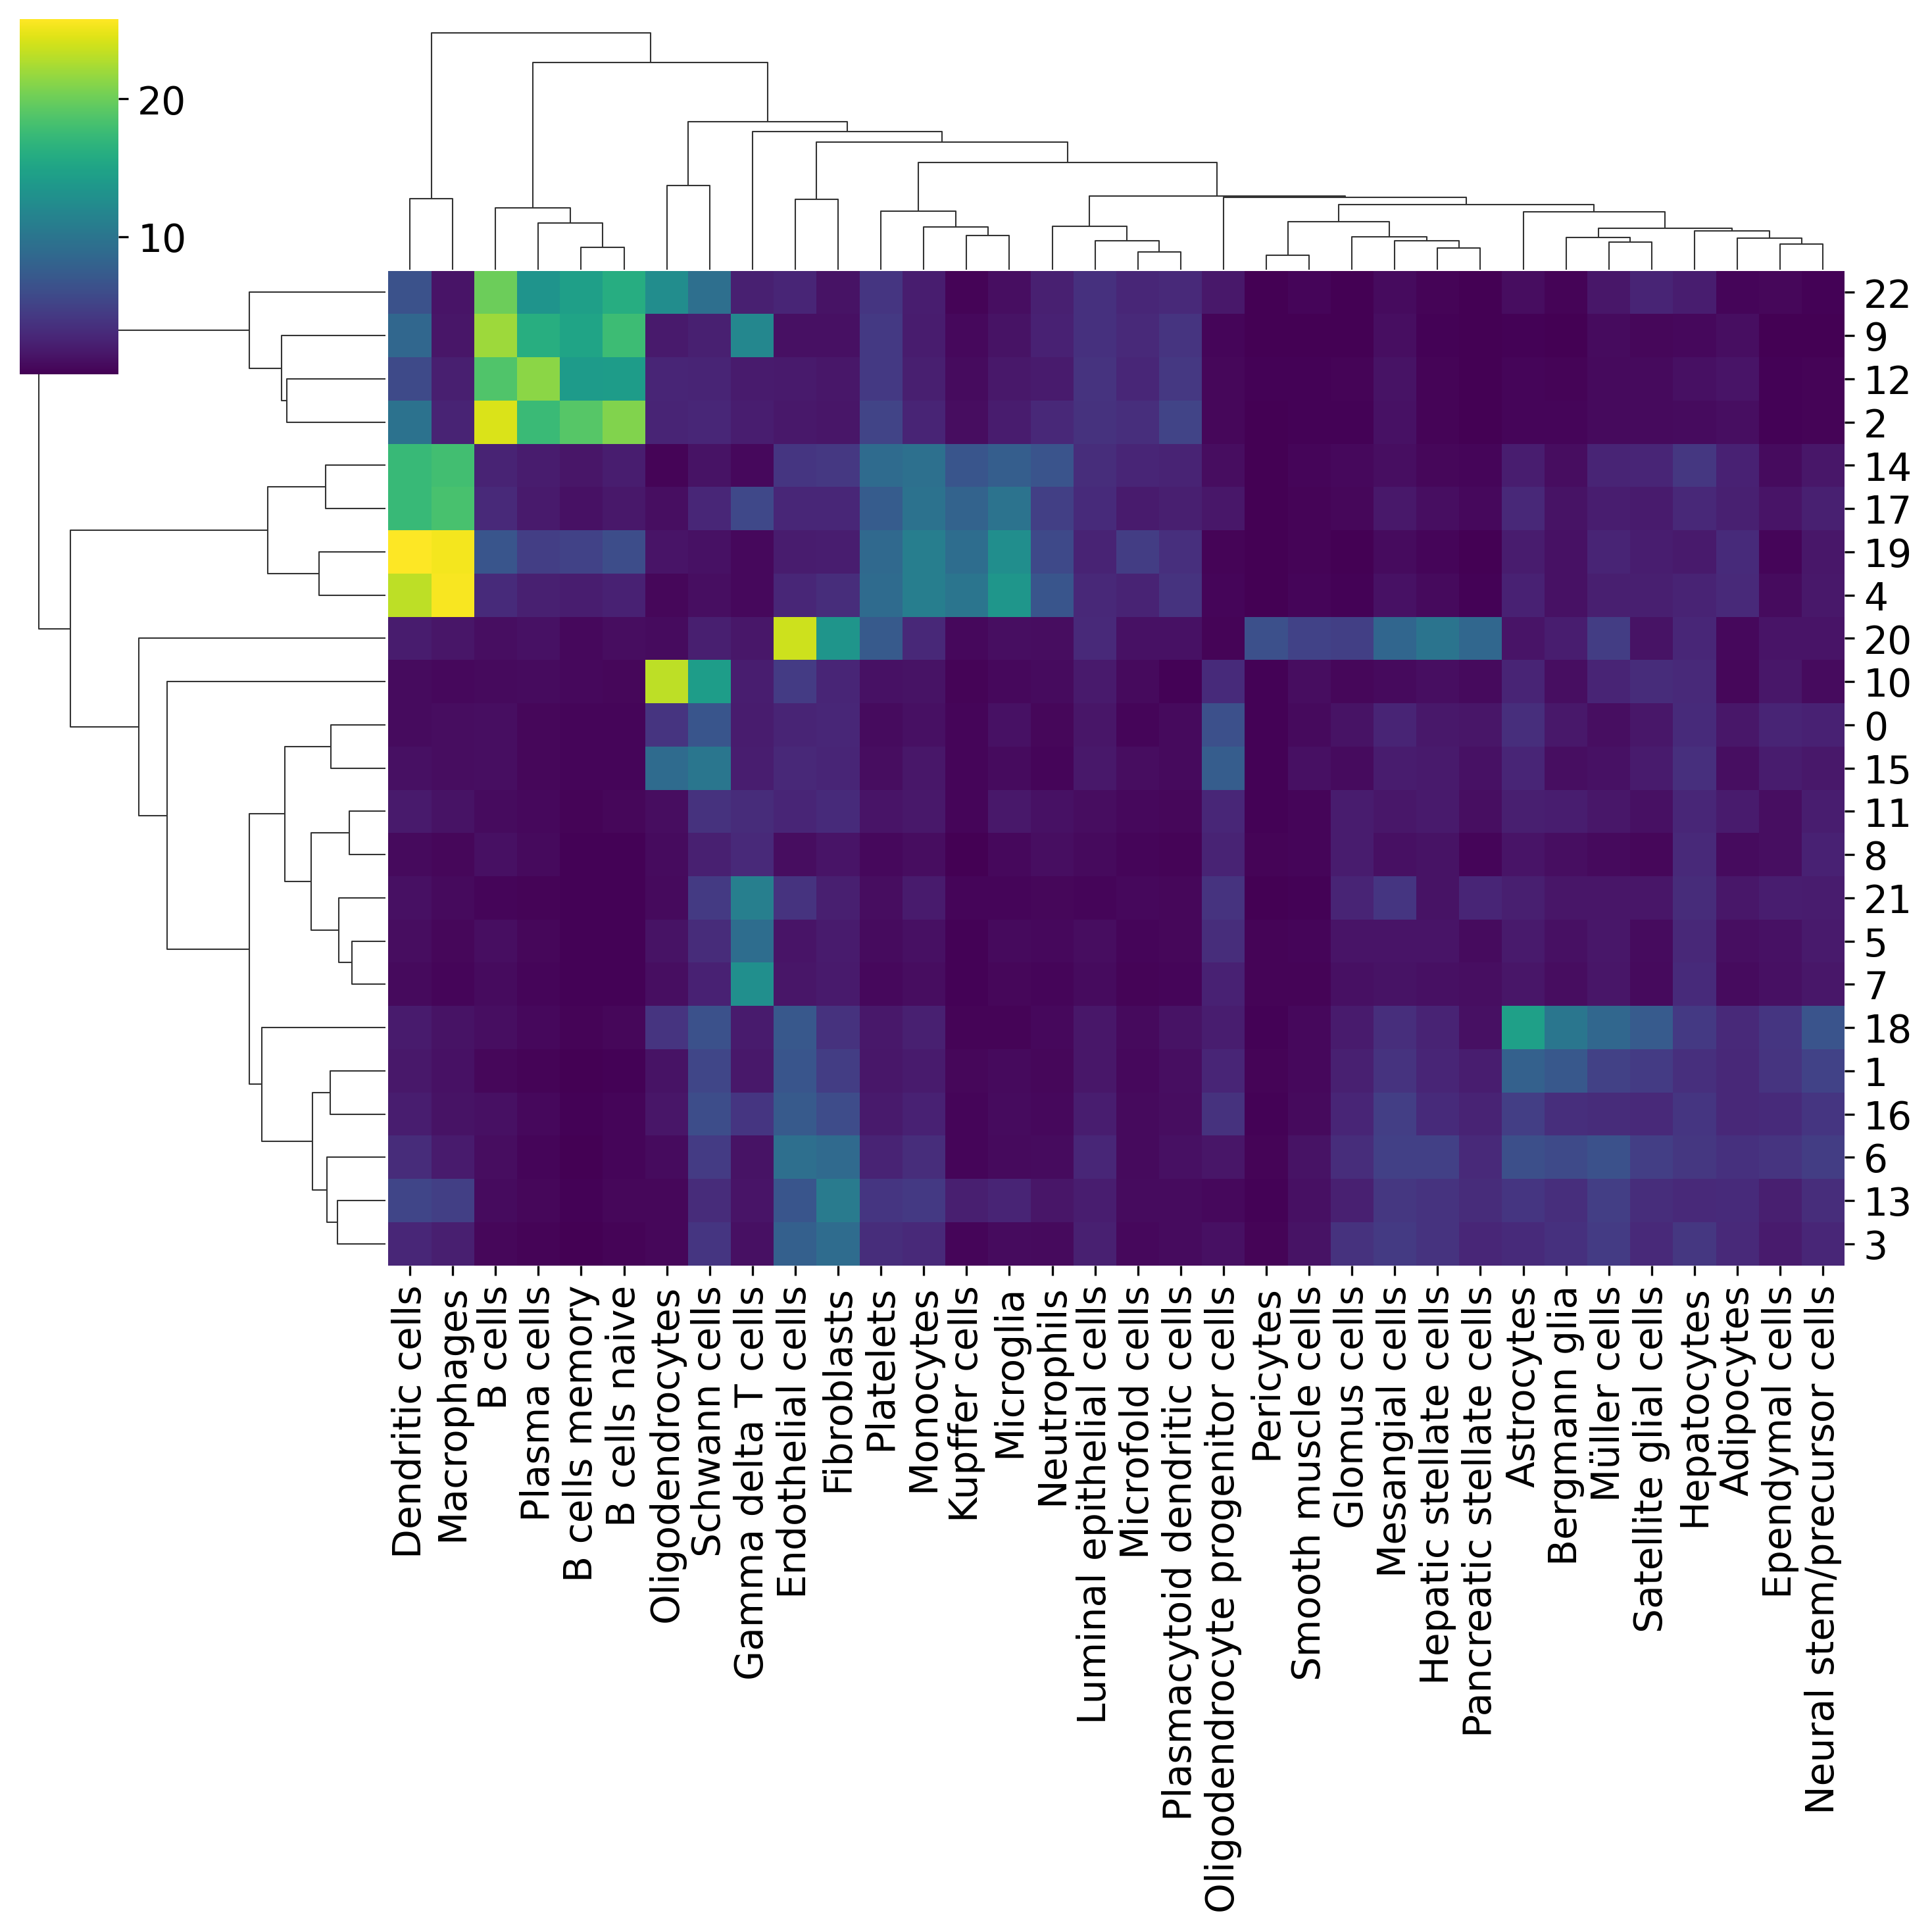

In [66]:
sns.clustermap(mean_enr, xticklabels=mean_enr.columns, cmap='viridis')
plt.show()

In [67]:
annotation_dict = dc.assign_groups(mean_enr)
annotation_dict

{'0': 'Schwann cells',
 '1': 'Astrocytes',
 '10': 'Oligodendrocytes',
 '11': 'Schwann cells',
 '12': 'Plasma cells',
 '13': 'Fibroblasts',
 '14': 'Macrophages',
 '15': 'Schwann cells',
 '16': 'Endothelial cells',
 '17': 'Macrophages',
 '18': 'Astrocytes',
 '19': 'Dendritic cells',
 '2': 'B cells',
 '20': 'Endothelial cells',
 '21': 'Gamma delta T cells',
 '22': 'B cells',
 '3': 'Fibroblasts',
 '4': 'Macrophages',
 '5': 'Gamma delta T cells',
 '6': 'Endothelial cells',
 '7': 'Gamma delta T cells',
 '8': 'Gamma delta T cells',
 '9': 'B cells'}

... storing 'cell_type' as categorical


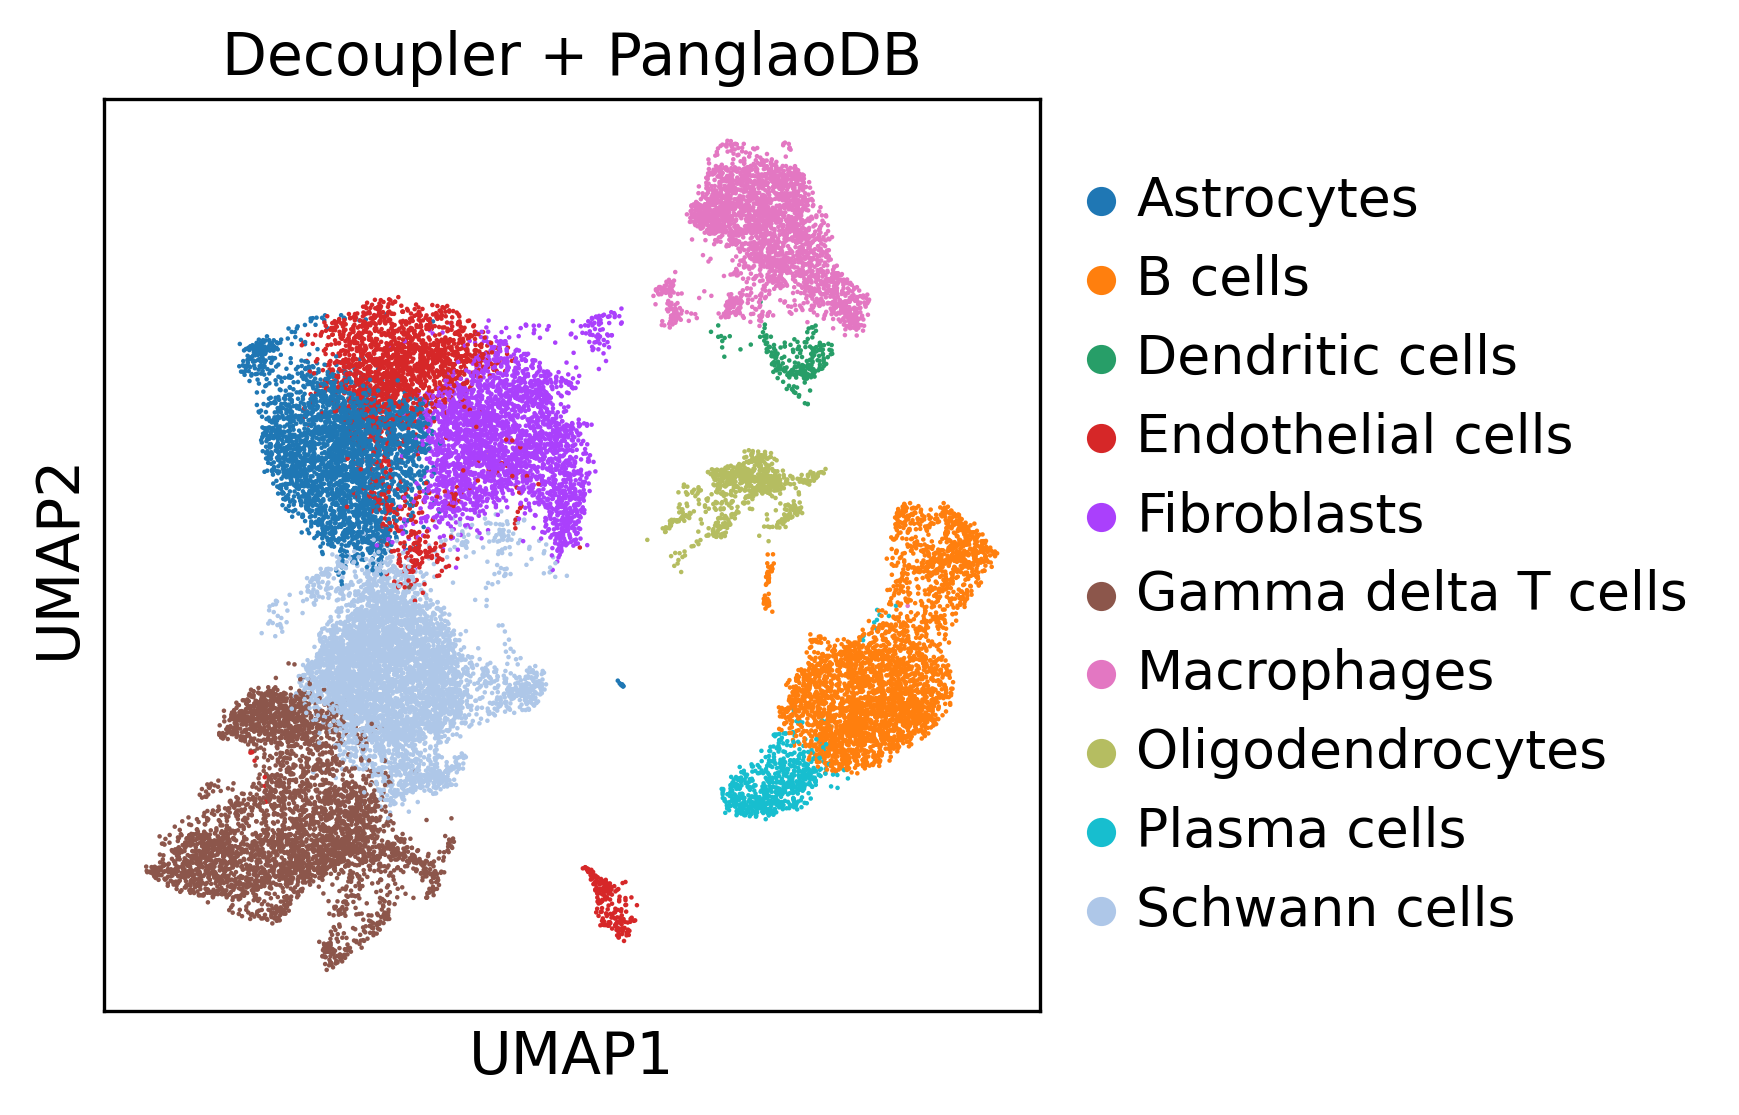

In [68]:
# Add cell type column based on annotation
adata.obs['cell_type'] = [annotation_dict[clust] for clust in adata.obs['leiden']]

# Visualize
sc.pl.umap(adata, color='cell_type',title='Decoupler + PanglaoDB')

In [69]:
adata

AnnData object with n_obs × n_vars = 25305 × 2911
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'leiden', 'cell_type'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'SampleID_colors', 'doublet_info_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'majority_voting_colors', 'leiden_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X

In [70]:
adata.write("/home/lugli/spuccio/Projects/SP039/FileH5AD_concatenated/Part1_Q_PRJNA579593_PMID31901251.h5ad")